In [11]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
import numpy as np

def compute_observables(t_max=5, dt=0.1, trotter_steps=10):
    """Compute expectation values and correlations over time"""
    times = np.arange(0, t_max, dt)
    z_vals = []
    correlations = []
    
    ideal_simulator = AerSimulator()
    
    for t in times:
        # Compute <Z(t)>
        qc_z = QuantumCircuit(1)
        qc_z.h(0)
        # Time evolution would go here
        qc_z.measure_all()
        job = ideal_simulator.run(qc_z, shots=1000)
        z_vals.append(job.result().get_counts().get('0', 0)/1000)
        
        # Compute <Z(t)Z(0)> correlation
        qc_corr = dynamical_correlation(t, trotter_steps)
        job = ideal_simulator.run(qc_corr, shots=1000)
        counts = job.result().get_counts()
        correlations.append((counts.get('00', 0) - counts.get('01', 0) 
                           - counts.get('10', 0) + counts.get('11', 0))/1000)
    
    return times, z_vals, correlations

# Run the computation
times, z_vals, correlations = compute_observables()

In [12]:
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error

def analyze_noise_impact(t_max=5, dt=0.1, trotter_steps=10):
    """Study fidelity degradation with noise over time"""
    # Create noise model
    noise_model = NoiseModel()
    error_gate1 = depolarizing_error(0.01, 1)
    error_gate2 = depolarizing_error(0.05, 2)
    noise_model.add_all_qubit_quantum_error(error_gate1, ['h', 'rz'])
    noise_model.add_all_qubit_quantum_error(error_gate2, ['rzz'])
    
    noisy_simulator = AerSimulator(noise_model=noise_model)
    ideal_simulator = AerSimulator()
    
    fidelities = []
    for t in np.arange(0, t_max, dt):
        qc = dynamical_correlation(t, trotter_steps)
        
        # Get ideal state
        ideal_result = ideal_simulator.run(qc).result()
        ideal_counts = ideal_result.get_counts()
        
        # Get noisy state
        noisy_result = noisy_simulator.run(qc, shots=1000).result()
        noisy_counts = noisy_result.get_counts()
        
        # Compute fidelity (simplified version)
        fid = 0
        for key in ideal_counts:
            fid += np.sqrt(ideal_counts[key]/1000 * noisy_counts.get(key, 0)/1000)
        fidelities.append(fid)
    
    return np.arange(0, t_max, dt), fidelities

# Run noise analysis
times, fidelities = analyze_noise_impact()

Trotter error (TVD): 0.0036
Hardware error (TVD): 0.4524


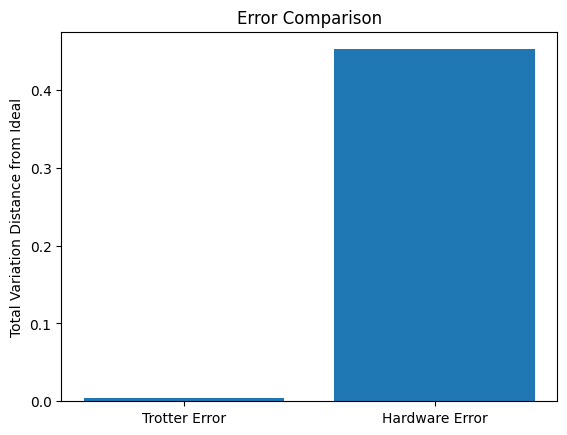

In [14]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
import matplotlib.pyplot as plt

def error_analysis():
    """Compare Trotter vs hardware errors"""
    # Ideal simulation (no noise, fine Trotter steps)
    ideal_simulator = AerSimulator()
    qc_ideal = dynamical_correlation(2.0, 100)  # Fine Trotter steps
    ideal_counts = ideal_simulator.run(qc_ideal, shots=10000).result().get_counts()
    
    # Trotter error (no noise, coarse steps)
    qc_trotter = dynamical_correlation(2.0, 5)  # Coarse Trotter steps
    trotter_counts = ideal_simulator.run(qc_trotter, shots=10000).result().get_counts()
    
    # Hardware error (noise, fine steps)
    noise_model = NoiseModel()
    # 1-qubit errors
    error_1q = depolarizing_error(0.01, 1)
    noise_model.add_all_qubit_quantum_error(error_1q, ['h', 'rz'])
    # 2-qubit errors
    error_2q = depolarizing_error(0.05, 2)
    noise_model.add_all_qubit_quantum_error(error_2q, ['rzz'])
    
    noisy_simulator = AerSimulator(noise_model=noise_model)
    noisy_counts = noisy_simulator.run(qc_ideal, shots=10000).result().get_counts()
    
    # Compute TVD (total variation distance) from ideal
    def tvd(counts1, counts2):
        keys = set(counts1).union(set(counts2))
        return 0.5*sum(abs(counts1.get(k,0)/10000 - counts2.get(k,0)/10000) for k in keys)
    
    trotter_error = tvd(ideal_counts, trotter_counts)
    hardware_error = tvd(ideal_counts, noisy_counts)
    
    print(f"Trotter error (TVD): {trotter_error:.4f}")
    print(f"Hardware error (TVD): {hardware_error:.4f}")
    
    # Plot results
    plt.bar(['Trotter Error', 'Hardware Error'], [trotter_error, hardware_error])
    plt.ylabel('Total Variation Distance from Ideal')
    plt.title('Error Comparison')
    plt.show()

error_analysis()